<a href="https://colab.research.google.com/github/NasiluFred/Breast_Cancer_Prediction/blob/main/BCP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

Load the data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/breast-cancer-dataset.csv')
data.set_index('S/N', inplace=True)
data.head()

Year  Age  Menopause Tumor Size (cm) Inv-Nodes Breast Metastasis  \
S/N                                                                     
1    2019   40          1               2         0  Right          0   
2    2019   39          1               2         0   Left          0   
3    2019   45          0               4         0   Left          0   
4    2019   26          1               3         0   Left          0   
5    2019   21          1               1         0  Right          0   

    Breast Quadrant History Diagnosis Result  
S/N                                           
1       Upper inner       0           Benign  
2       Upper outer       0           Benign  
3       Lower outer       0           Benign  
4       Lower inner       1           Benign  
5       Upper outer       1           Benign

Finding the class name and determining how the class is balanced

In [ ]:
data['Diagnosis Result'].value_counts()

Benign       120
Malignant     93
Name: Diagnosis Result, dtype: int64

Define X and Y and Train Test Split

In [ ]:
#dropping Irrelevant feature
cols_drop = ['Year']

# Create features matrix and target vector
X = data.drop(columns=[*cols_drop, 'Diagnosis Result'])
y = data['Diagnosis Result']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

Creating a  Column Transformer for Preprocessing.

Defining a preprocessing pipeline for numeric and
categorical data. Then include both in a single transformer object.

In [ ]:
# Categorical Preprocessing Pipeline
# Save list of column names
ohe_cols = X_train.select_dtypes('object').columns
print("OneHotEncoder Columns:", ohe_cols)
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy='constant', fill_value = "Missing")
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)

# Numerical Preprocessing Pipeline
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)
# Create the Column Transformer
preprocessor = ColumnTransformer([num_tuple, ohe_tuple],
                                 verbose_feature_names_out=False)

OneHotEncoder Columns: Index(['Tumor Size (cm)', 'Inv-Nodes', 'Breast', 'Metastasis',
       'Breast Quadrant', 'History'],
      dtype='object')
Numeric Columns: Index(['Age', 'Menopause'], dtype='object')


Making Model Pipeline and Fitting on Training Data
First, instantiating a KNN model.A default model where n_neighbors =5.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# Instantiate default KNN
knn = KNeighborsClassifier()

Making the model pipeline with the preprocessing object and the KNN model.

In [ ]:
# Define KNN model pipeline
knn_pipe = make_pipeline(preprocessor, knn)
# Fit the model on the training data
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Menopause'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Tumor Size (cm)', 'Inv-Nodes', 'Breast', 'Metastasis',
       'Breast Quadrant', 'History'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('kneighborsclassifier', KNeighborsClassifier())])

Define Custom Functions

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOT
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray',colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap,colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  fig.tight_layout()
  plt.show()
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict



**Evaluate**

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      Benign       0.85      0.98      0.91        84
   Malignant       0.97      0.80      0.88        75

    accuracy                           0.89       159
   macro avg       0.91      0.89      0.89       159
weighted avg       0.90      0.89      0.89       159



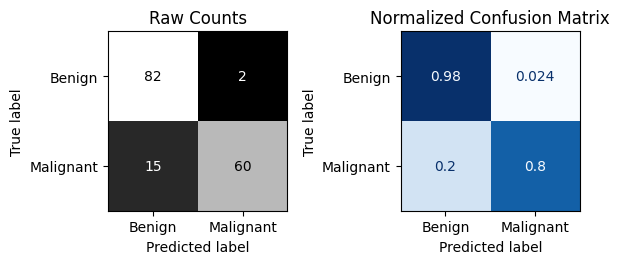


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      Benign       0.90      1.00      0.95        36
   Malignant       1.00      0.78      0.88        18

    accuracy                           0.93        54
   macro avg       0.95      0.89      0.91        54
weighted avg       0.93      0.93      0.92        54



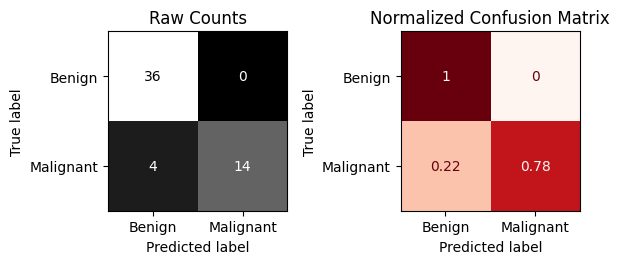

In [ ]:
# Obtain evaluation metrics using custom function
evaluate_classification(knn_pipe, X_train, y_train, X_test, y_test)

**Results**
*   High Accuracy




Finding the best k value

In [ ]:
# Making every other value from the range (odd values)
nneighbors_list = list(range(1,33,2))
nneighbors_list

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]

In [ ]:
# Get list of params for the knn model pipeline
knn_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Age', 'Menopause'], dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='Missing',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                        

creating the param grid using kneighborsclassifier__n_neighbors.

In [ ]:
# Create param grid
params={'kneighborsclassifier__n_neighbors': nneighbors_list}

Instantiate GridSearchCV, Fit, and get the Best K

In [ ]:
# Instaniate GridSearchCV
gs = GridSearchCV(knn_pipe, params, scoring='recall_macro', cv=3 , verbose=True, n_jobs=-1)
# Fit gs on training data
gs.fit(X_train, y_train)
# Obtain best param value for K
best_param =gs.best_params_
best_param

Fitting 3 folds for each of 16 candidates, totalling 48 fits


{'kneighborsclassifier__n_neighbors': 13}

Extract the best k value

In [ ]:
best_k = best_param['kneighborsclassifier__n_neighbors']


In [ ]:
best_k

13

Train the final model using the best k value

Making the model pipeline with the preprocessing object and the KNN model.

In [ ]:
final_model = KNeighborsClassifier(n_neighbors=best_k)

In [ ]:
# Define KNN model pipeline
final_knn_pipe = make_pipeline(preprocessor, final_model)
# Fit the model on the training data
final_knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Menopause'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Tumor Size (cm)', 'Inv-Nodes', 'Breast', 'Metastasis',
       'Breast Quadrant', 'History'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=13))])

Evaluate

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      Benign       0.83      0.99      0.90        84
   Malignant       0.98      0.77      0.87        75

    accuracy                           0.89       159
   macro avg       0.91      0.88      0.88       159
weighted avg       0.90      0.89      0.88       159



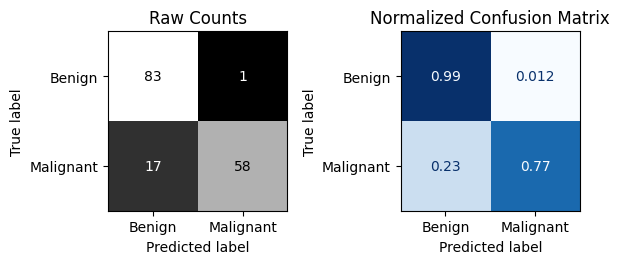


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      Benign       0.90      1.00      0.95        36
   Malignant       1.00      0.78      0.88        18

    accuracy                           0.93        54
   macro avg       0.95      0.89      0.91        54
weighted avg       0.93      0.93      0.92        54



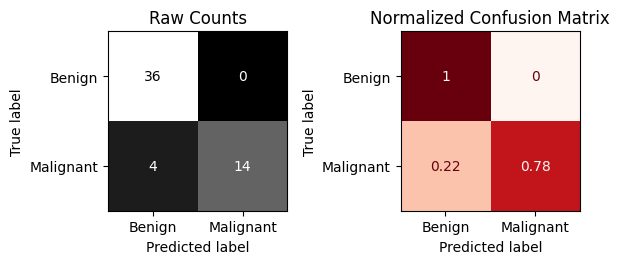

In [ ]:
# Obtain evaluation metrics using custom function
evaluate_classification(final_knn_pipe, X_train, y_train, X_test, y_test)

In [ ]:
final_knn_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Age', 'Menopause'], dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='Missing',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                        

**Logistic Regression**

Creating a Logistic regression model

In [ ]:
# Instantiate  default LogisticRegression model
default_LR_model = LogisticRegression(random_state=42)

Making the model pipeline with the preprocessing object and the default_LR model.

In [ ]:
# Define LR model pipeline
LR_pipe = make_pipeline(preprocessor, default_LR_model)
# Fit the model on the training data
LR_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Menopause'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Tumor Size (cm)', 'Inv-Nodes', 'Breast', 'Metastasis',
       'Breast Quadrant', 'History'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('logisticregression', LogisticRegression(random_state=42))])

Evaluate default Logistic Regression

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      Benign       0.88      0.96      0.92        84
   Malignant       0.96      0.85      0.90        75

    accuracy                           0.91       159
   macro avg       0.92      0.91      0.91       159
weighted avg       0.92      0.91      0.91       159



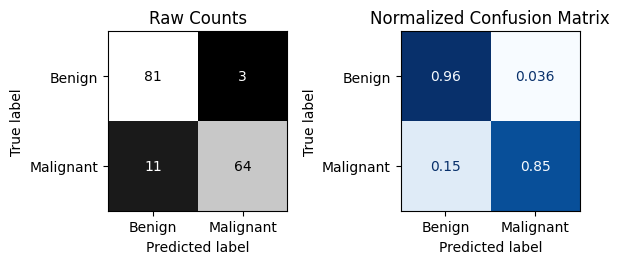


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      Benign       0.92      0.97      0.95        36
   Malignant       0.94      0.83      0.88        18

    accuracy                           0.93        54
   macro avg       0.93      0.90      0.91        54
weighted avg       0.93      0.93      0.92        54



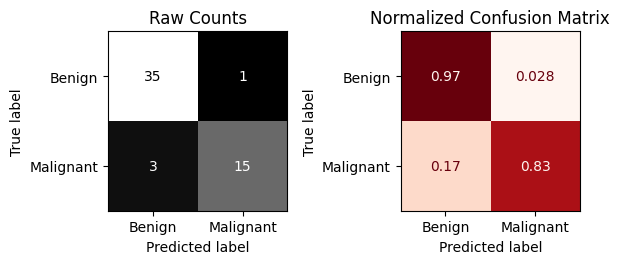

In [ ]:
# Obtain evaluation metrics using custom function
evaluate_classification(LR_pipe, X_train, y_train, X_test, y_test)

In [ ]:
# Get list of params for the LR model pipeline
LR_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Age', 'Menopause'], dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='Missing',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                        

Creating the param grid

In [ ]:
#making a list of parameters
solver= ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty= ['l1', 'l2', 'elasticnet']
C_values =[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
class_weight = ['None', 'balanced']


In [ ]:
# Define hyperparameters for tuning
param_grid = {
    'logisticregression__solver': solver,
    'logisticregression__penalty': penalty,
     'logisticregression__C': C_values,
     'logisticregression__class_weight':class_weight,
}


In [ ]:
# Instantiate GridSearchCV with 'recall_macro' scoring
gridsearch = GridSearchCV(LR_pipe, param_grid, scoring='recall_macro', cv=3 , verbose=True, n_jobs=-1)
# Fit gridsearch on training data
gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 270 candidates, totalling 810 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
621 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1160, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/d

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Age', 'Menopause'], dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='Missing',
                                                                                                        strategy='c...
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                                   10, 100, 1000, 10000],
                         'logisticregression__class_weight': ['None',
                                                              'balanced'],
                         'logisticregression__penalty': ['l1', 'l2',
                                                         'elasticnet'],
                         'logisticregression__solver': ['newton-cg', 'lbfgs',
                                                        'liblinear', 'sag',
                                                        'saga']},
             scoring='recall_macro', verbose=True)

Evaluate **Tuned** Logistic Regression

In [ ]:
y_pred_tuned =gridsearch.predict(X_test)


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      Benign       0.90      0.96      0.93        84
   Malignant       0.96      0.88      0.92        75

    accuracy                           0.92       159
   macro avg       0.93      0.92      0.92       159
weighted avg       0.93      0.92      0.92       159



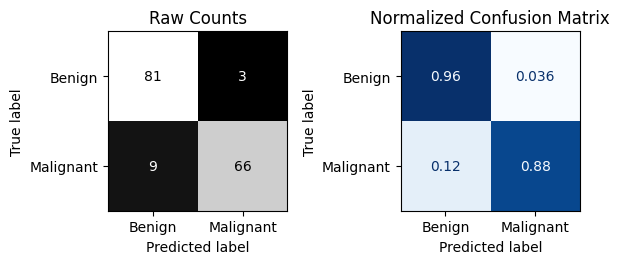


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

      Benign       0.92      0.97      0.95        36
   Malignant       0.94      0.83      0.88        18

    accuracy                           0.93        54
   macro avg       0.93      0.90      0.91        54
weighted avg       0.93      0.93      0.92        54



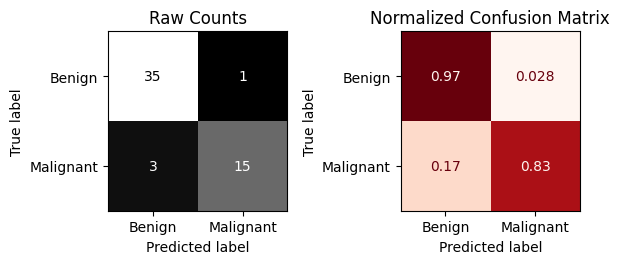

In [ ]:
# Obtain evaluation metrics using custom function
evaluate_classification(gridsearch, X_train, y_train, X_test, y_test)

In [ ]:
# Get the best parameters from the grid search
best_params = gridsearch.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'logisticregression__C': 1, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}


**Question 2**

Segment potential customers for the approriate cards.
Use K Means to create various customer segments

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Load the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cust_seg.csv')
df.head()

Unnamed: 0  Customer Id  Age  Edu  Years Employed  Income  Card Debt  \
0           0            1   41    2               6      19      0.124   
1           1            2   47    1              26     100      4.582   
2           2            3   33    2              10      57      6.111   
3           3            4   29    2               4      19      0.681   
4           4            5   47    1              31     253      9.308   

   Other Debt  Defaulted  DebtIncomeRatio  
0       1.073        0.0              6.3  
1       8.218        0.0             12.8  
2       5.802        1.0             20.9  
3       0.516        0.0              6.3  
4       8.908        0.0              7.2

In [ ]:
# removing Irrelevant data
columns_to_drop = [df.columns[0], 'Customer Id']
df = df.drop(columns=columns_to_drop)



In [ ]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              850 non-null    int64  
 1   Edu              850 non-null    int64  
 2   Years Employed   850 non-null    int64  
 3   Income           850 non-null    int64  
 4   Card Debt        850 non-null    float64
 5   Other Debt       850 non-null    float64
 6   Defaulted        700 non-null    float64
 7   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 53.2 KB


Age                  0
Edu                  0
Years Employed       0
Income               0
Card Debt            0
Other Debt           0
Defaulted          150
DebtIncomeRatio      0
dtype: int64

Handling missing values by imputing with mean

In [ ]:
# Defaulted has 150 missing values
df['Defaulted'].fillna(0, inplace=True)


Scaling the data

In [ ]:
# Instantiate Standard Scaler to reduce the bias in our data
scaler = StandardScaler()
# Fit & transform data.
scaled_df = scaler.fit_transform(df)

In [ ]:
df.columns

Index(['Age', 'Edu', 'Years Employed', 'Income', 'Card Debt', 'Other Debt',
       'Defaulted', 'DebtIncomeRatio'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Text(0, 0.5, 'inertias')

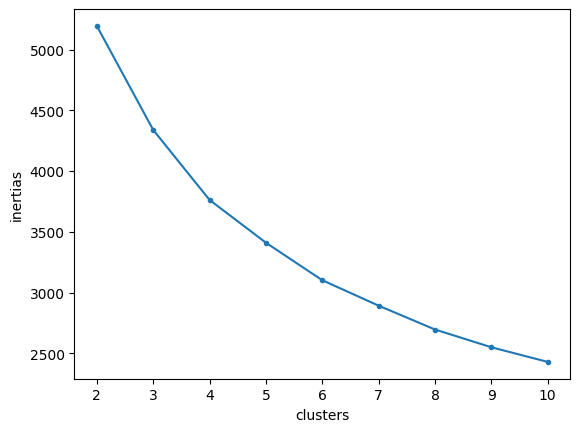

In [ ]:
#Case one: using the inertia elbow method

inertias = []

for k in range(2,11):
  kmeans = KMeans(n_clusters= k)
  kmeans.fit(scaled_df)
  inertias.append(kmeans.inertia_)

#visualise the score for the elbow plot
plt.plot(range(2,11), inertias, marker= '.');
plt.xlabel('clusters')
plt.ylabel('inertias')


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Text(0, 0.5, 'silhouette_score')

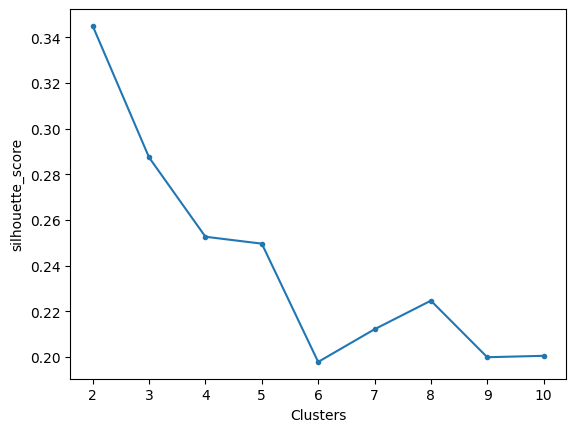

In [ ]:
# Case 2: Using silhouette score method

silhouette_scores =[]
for s in range(2,11):
  kmeans = KMeans(n_clusters = s)
  kmeans.fit(scaled_df)
  silhouette_scores.append(silhouette_score(scaled_df, kmeans.labels_))

#Visualization of the scores
plt.plot(range(2,11), silhouette_scores, marker = '.')
plt.xlabel('Clusters')
plt.ylabel('silhouette_score')

In [ ]:
kmeans2= KMeans(n_clusters = 2, n_init=10)
kmeans2.fit(scaled_df)
silhouette_score(scaled_df, kmeans2.labels_)

0.3375425850736682

In [ ]:
kmeans3= KMeans(n_clusters = 3, n_init=10)
kmeans3.fit(scaled_df)
silhouette_score(scaled_df, kmeans3.labels_)

0.28738683325129355

Create KMeans models to select the best model

In [ ]:
kmeans2 = KMeans(n_clusters = 2, n_init=10)
kmeans3 = KMeans(n_clusters = 3, n_init=10)
kmeans2.fit(scaled_df)
kmeans3.fit(scaled_df)

#Save these to the dataframe

df['cluster2'] = kmeans2.labels_
df['cluster3'] = kmeans3.labels_

**Create analytical visualizations that explore statistics for each feature for each cluster.**

In [ ]:
df.describe()

Age         Edu  Years Employed      Income   Card Debt  \
count  850.000000  850.000000      850.000000  850.000000  850.000000   
mean    35.029412    1.710588        8.565882   46.675294    1.576820   
std      8.041432    0.927784        6.777884   38.543054    2.125843   
min     20.000000    1.000000        0.000000   13.000000    0.012000   
25%     29.000000    1.000000        3.000000   24.000000    0.382500   
50%     34.000000    1.000000        7.000000   35.000000    0.885000   
75%     41.000000    2.000000       13.000000   55.750000    1.898500   
max     56.000000    5.000000       33.000000  446.000000   20.561000   

       Other Debt   Defaulted  DebtIncomeRatio    cluster2    cluster3  
count  850.000000  850.000000       850.000000  850.000000  850.000000  
mean     3.078773    0.215294        10.171647    0.201176    0.563529  
std      3.398799    0.411268         6.719441    0.401116    0.798312  
min      0.046000    0.000000         0.100000    0.000000    0.000000  
25%      1.045750    0.000000         5.100000    0.000000    0.000000  
50%      2.003000    0.000000         8.700000    0.000000    0.000000  
75%      3.903250    0.000000        13.800000    0.000000    1.000000  
max     35.197000    1.000000        41.300000    1.000000    2.000000

<Axes: >

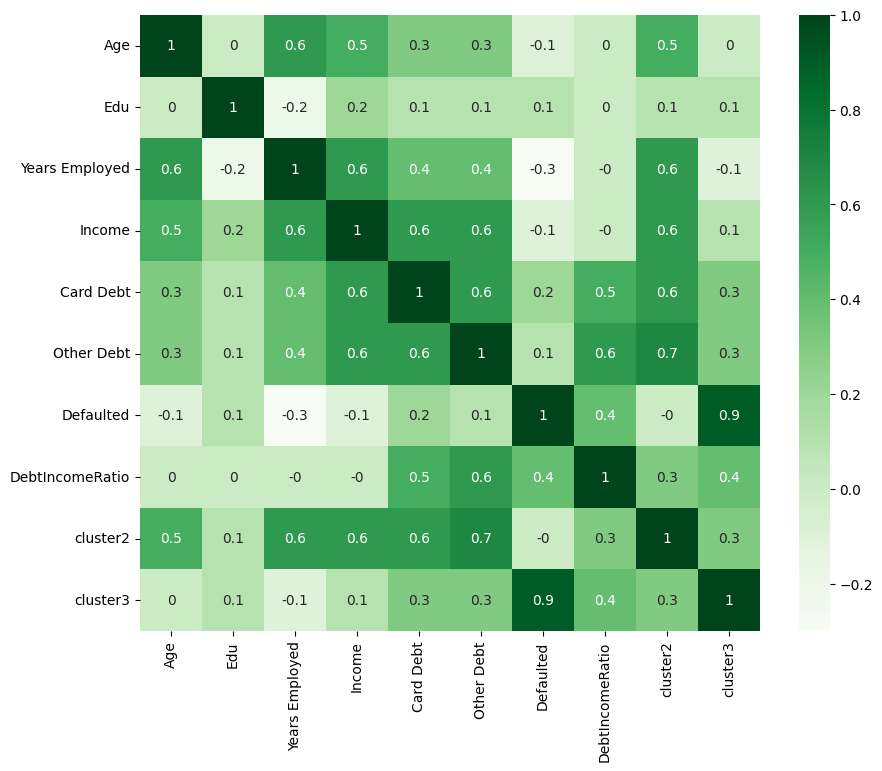

In [ ]:
# correlation
corr = df.corr(numeric_only = True)
fir,ax = plt.subplots(figsize = (10,8))
sns.heatmap(corr.round(1), cmap = 'Greens', annot = True)

Age is our strongest determinant

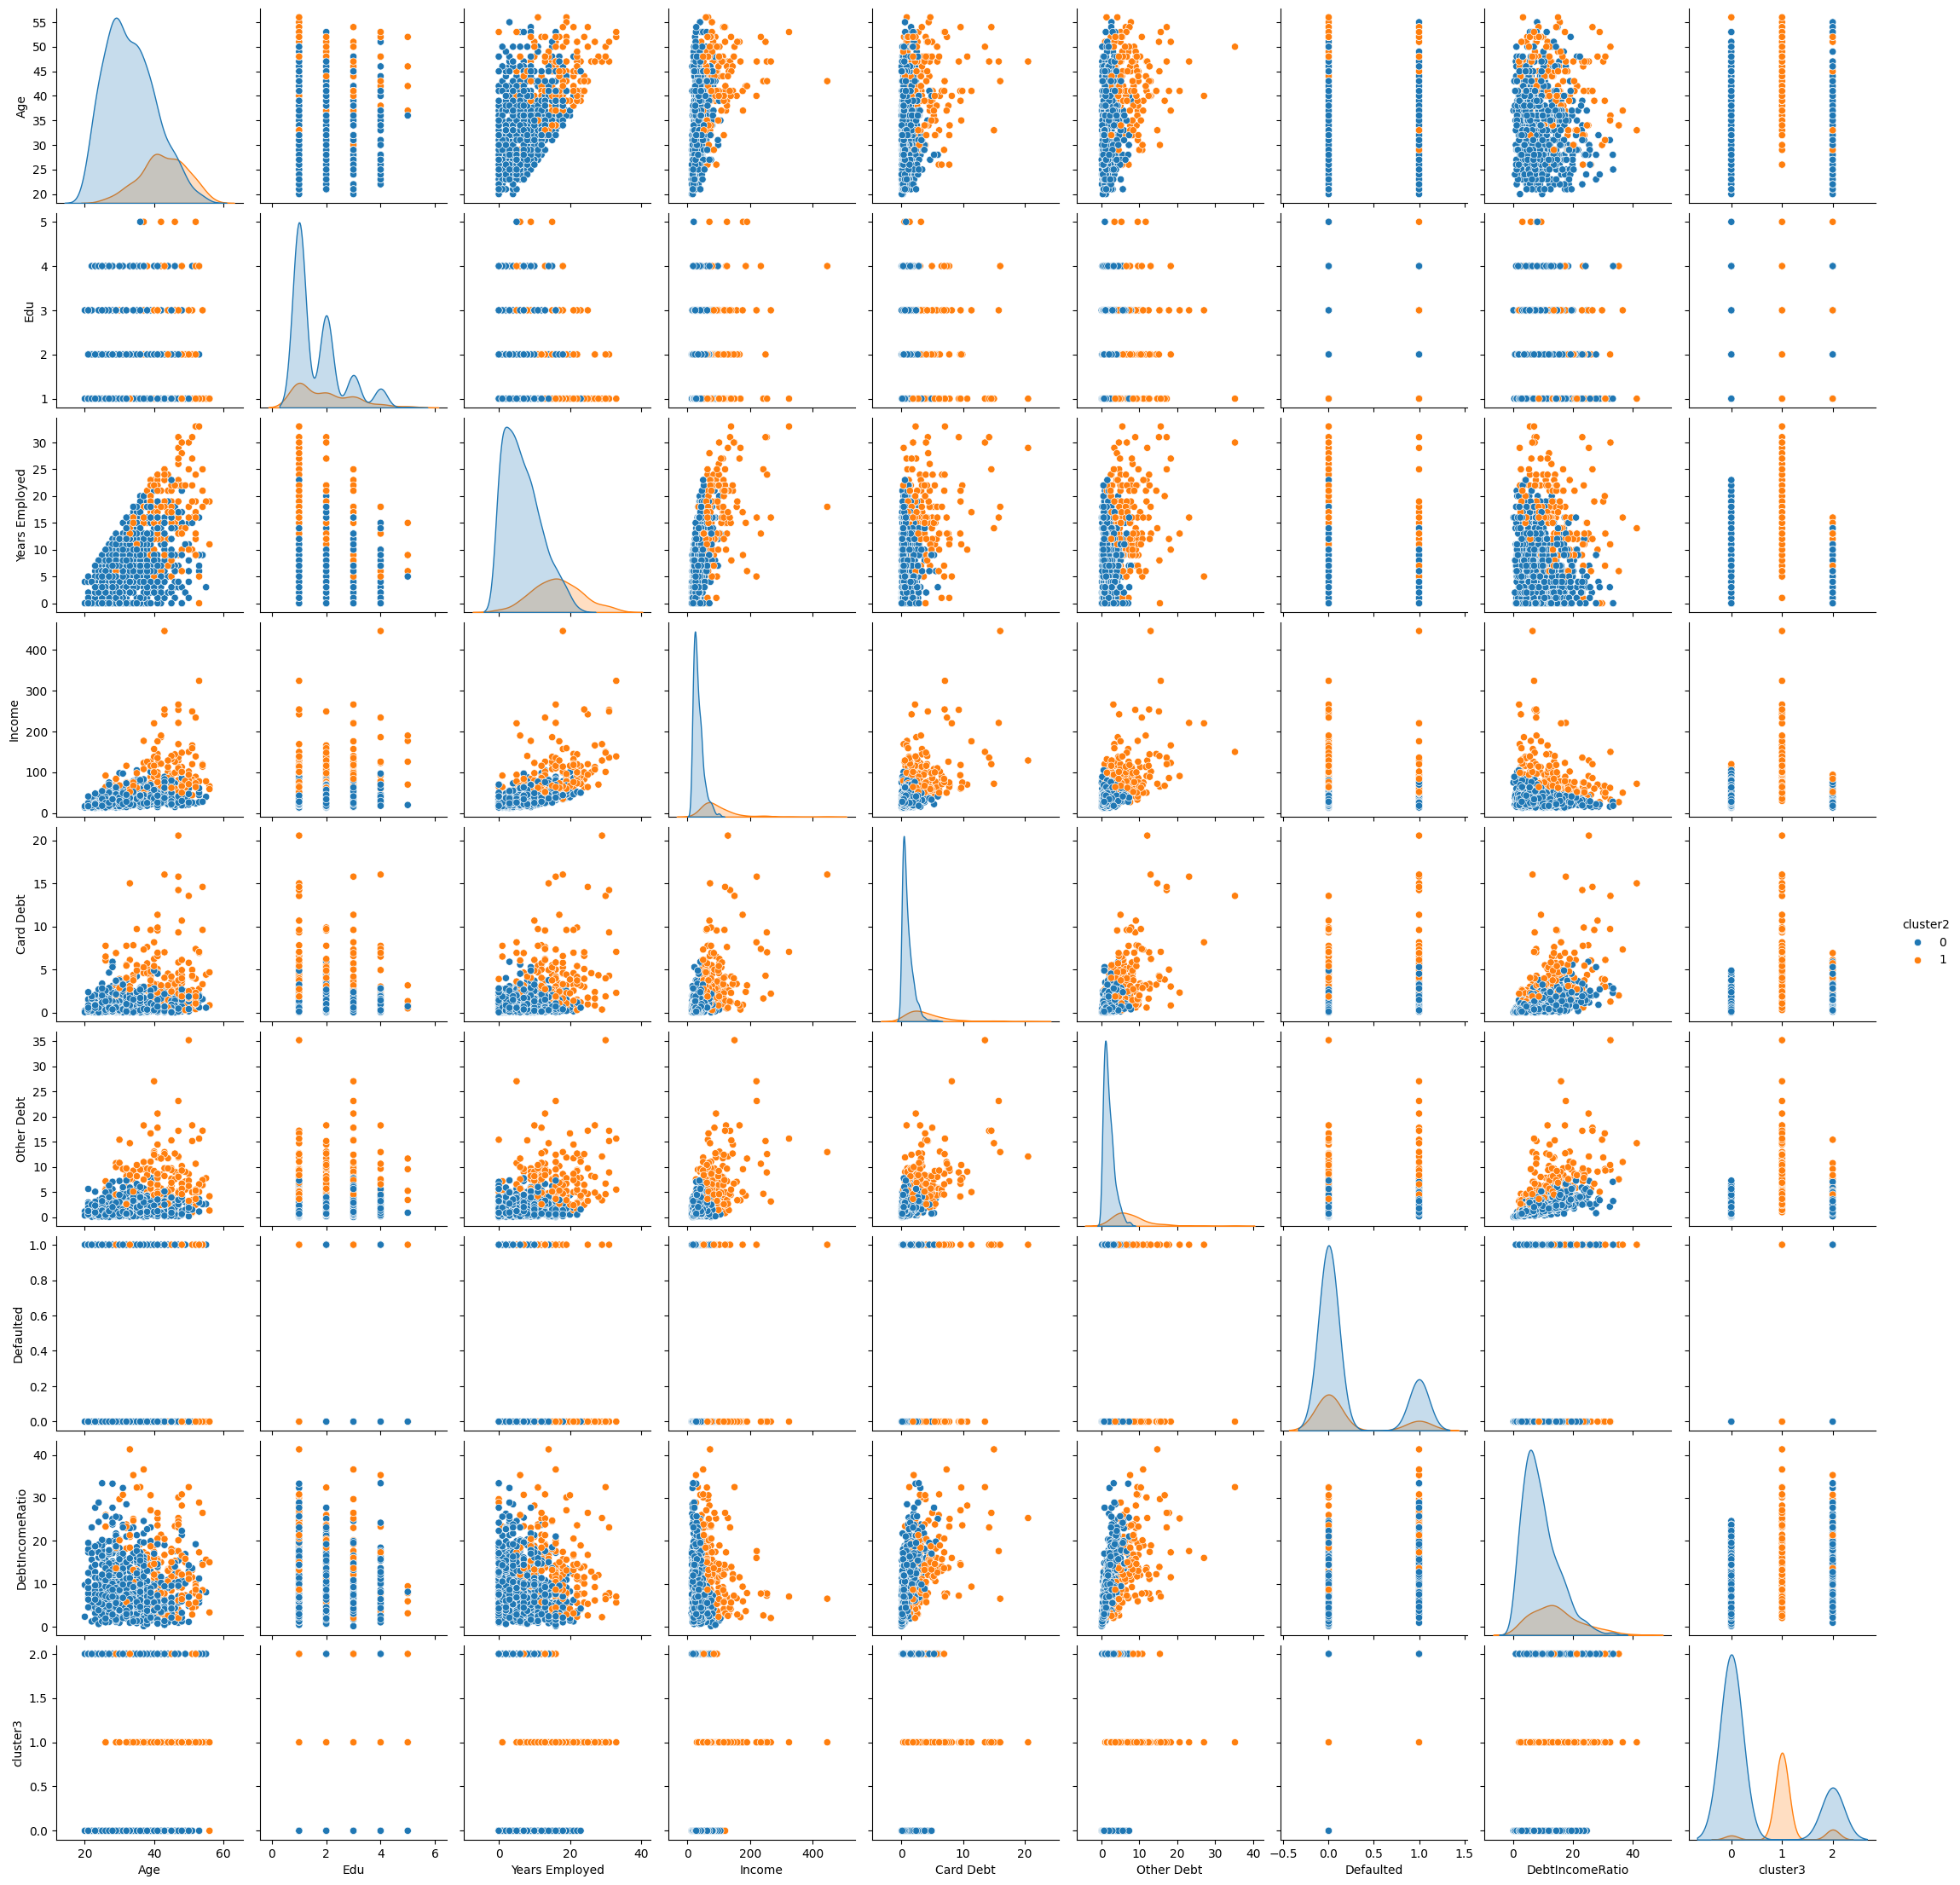

In [ ]:
sns.pairplot(df, hue = 'cluster2')
plt.show()

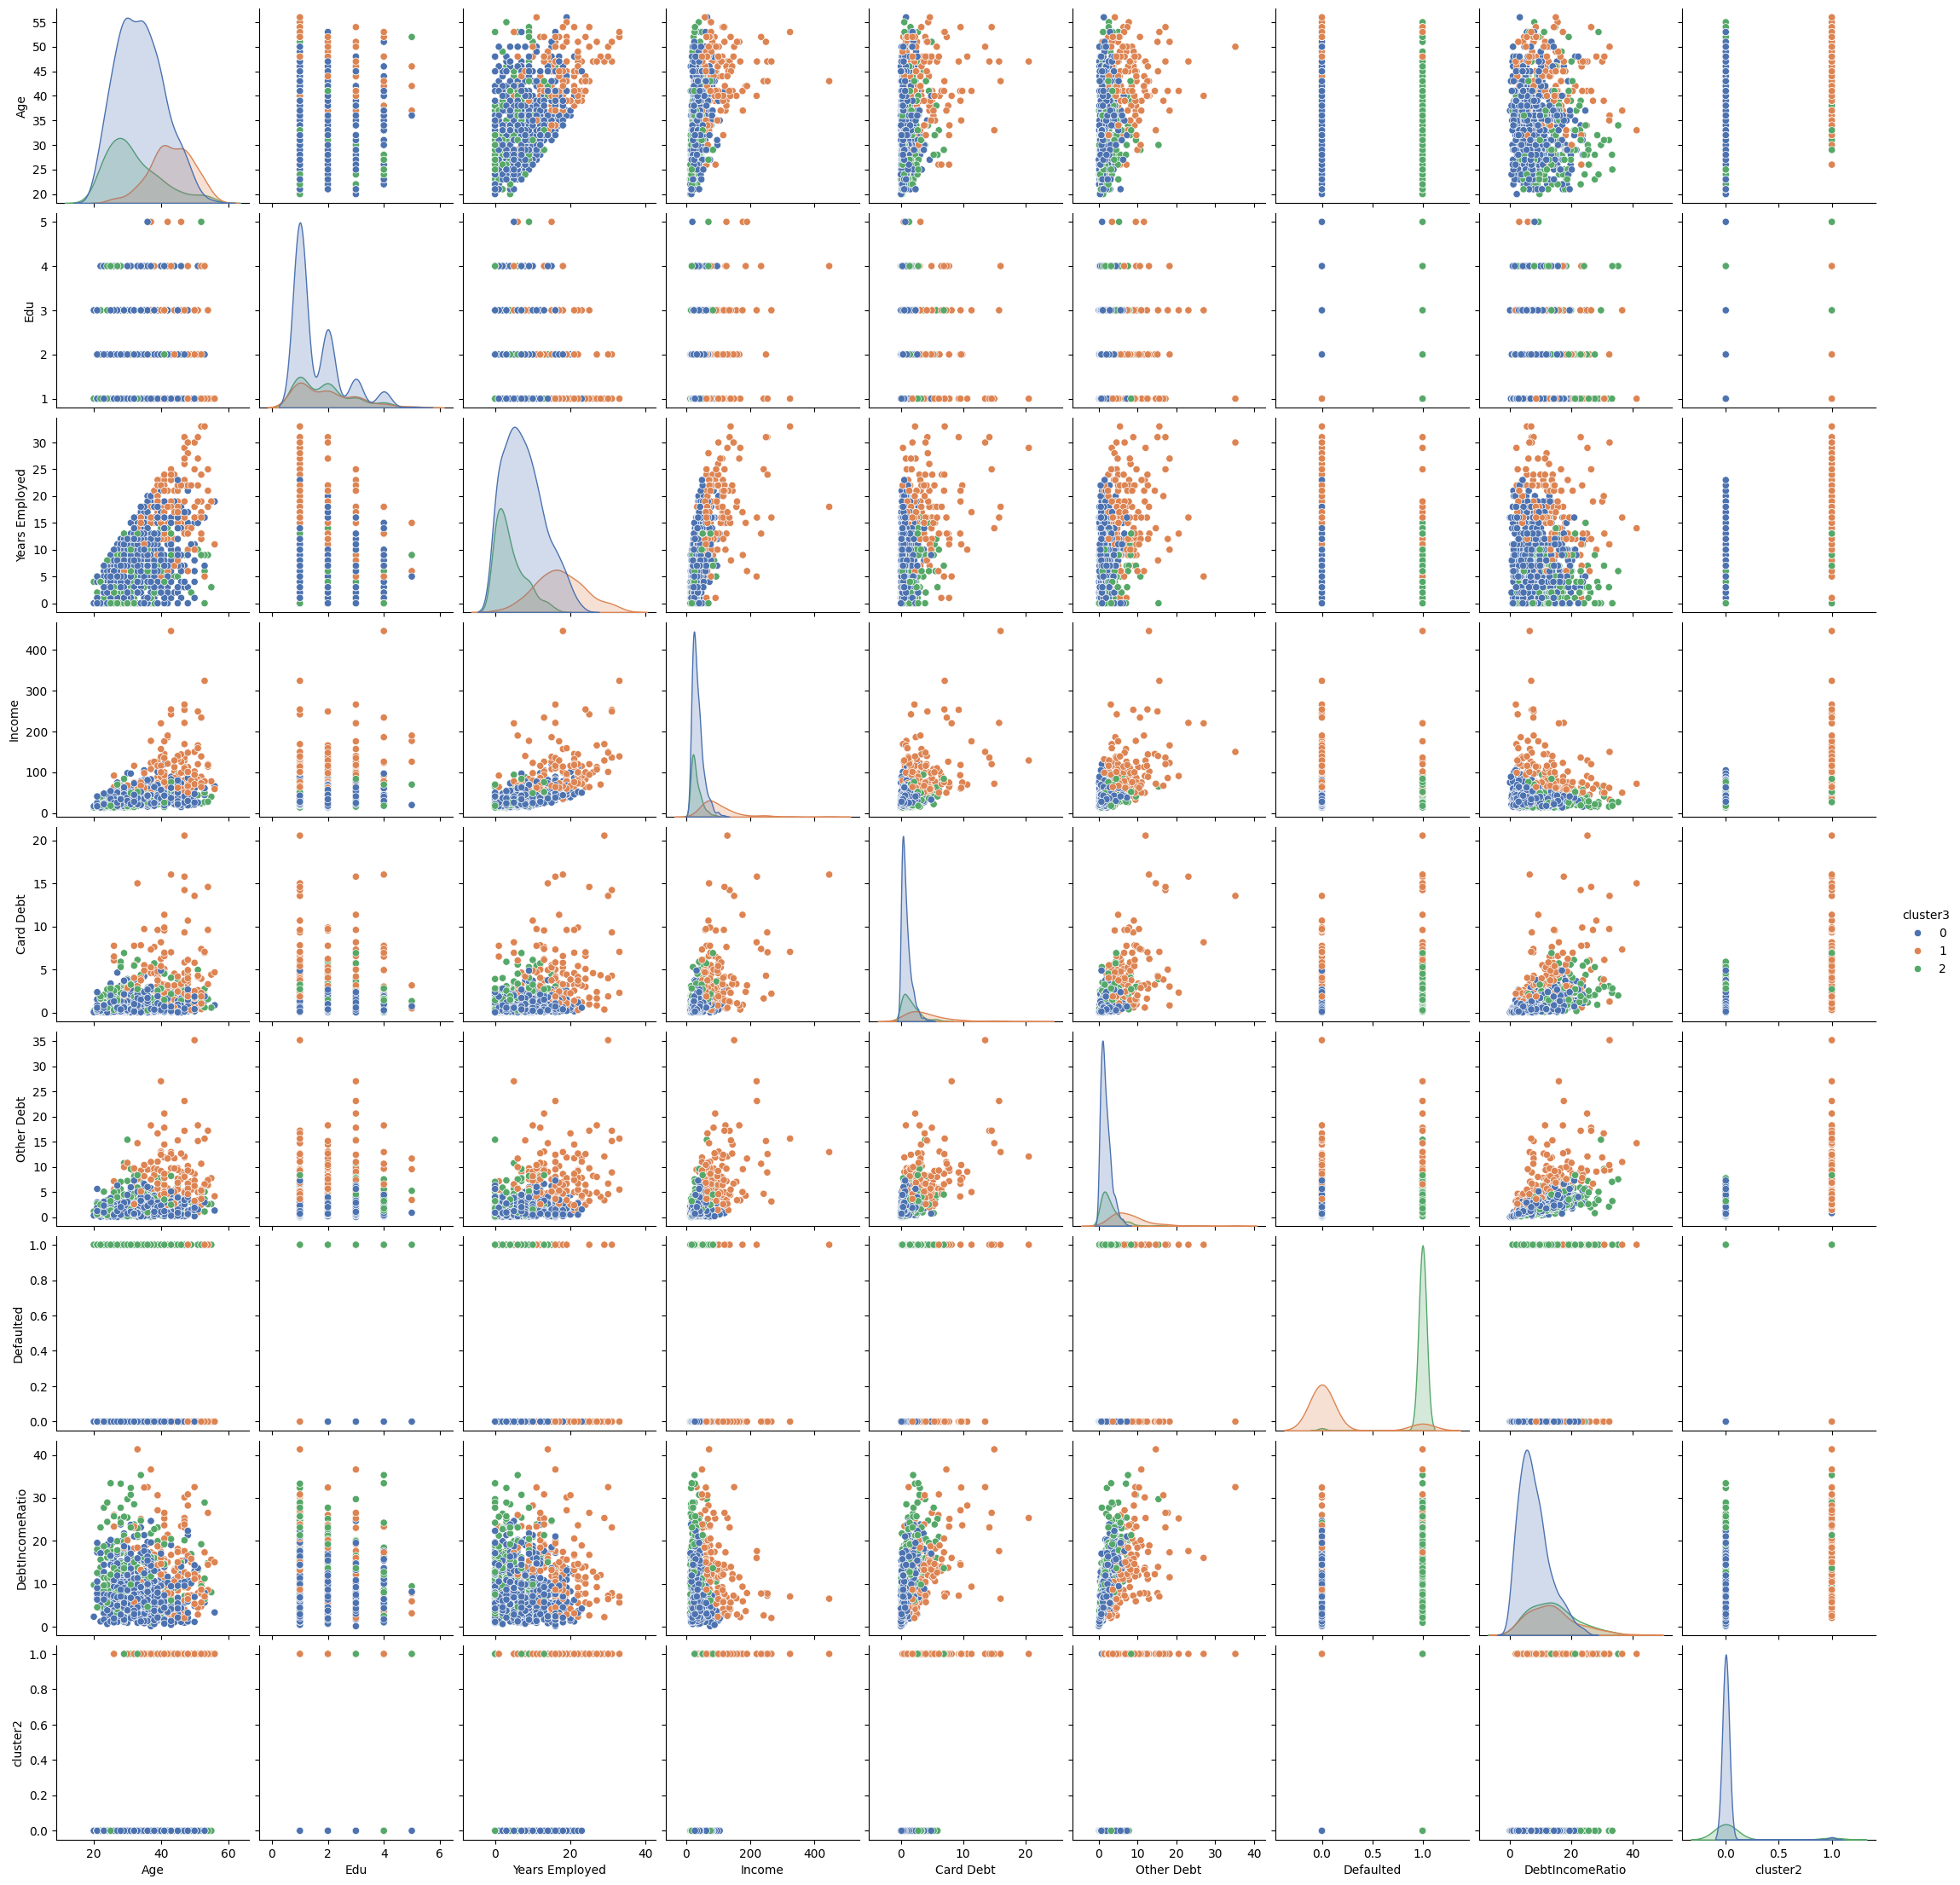

In [ ]:
sns.pairplot(df, hue = 'cluster3', palette = 'deep')
plt.show()

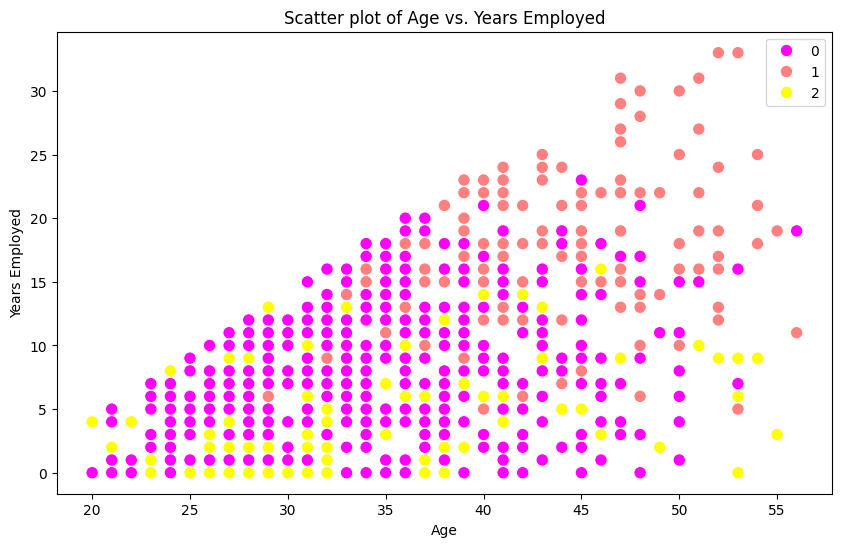

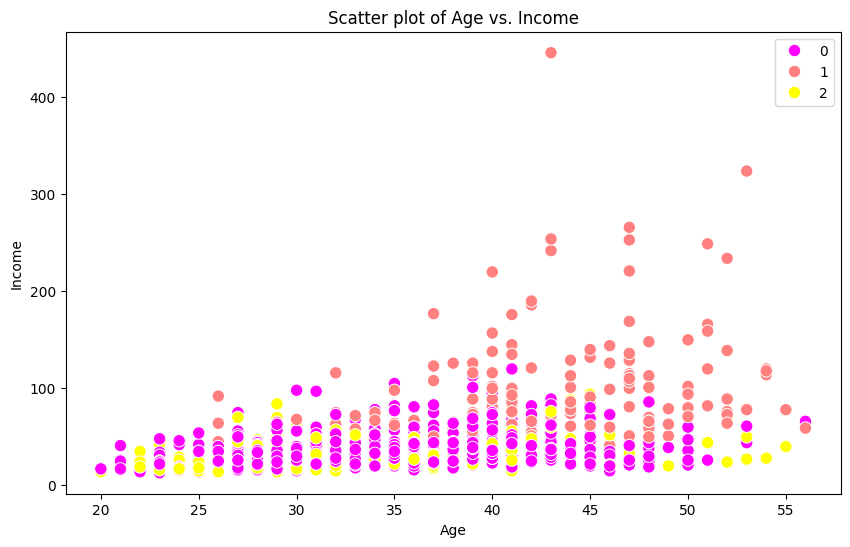

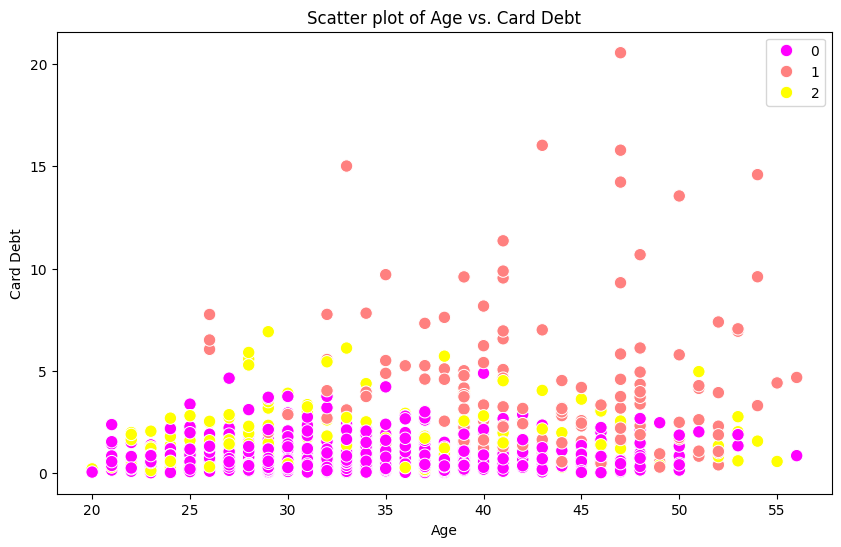

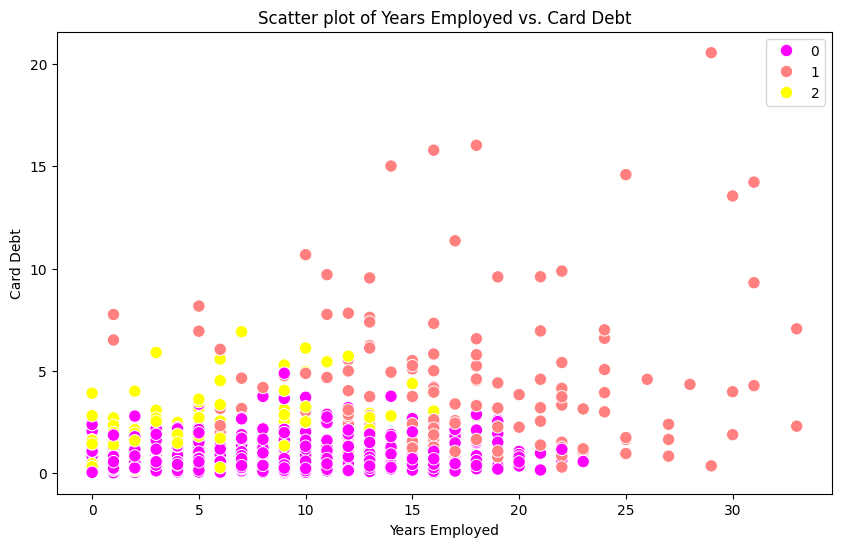

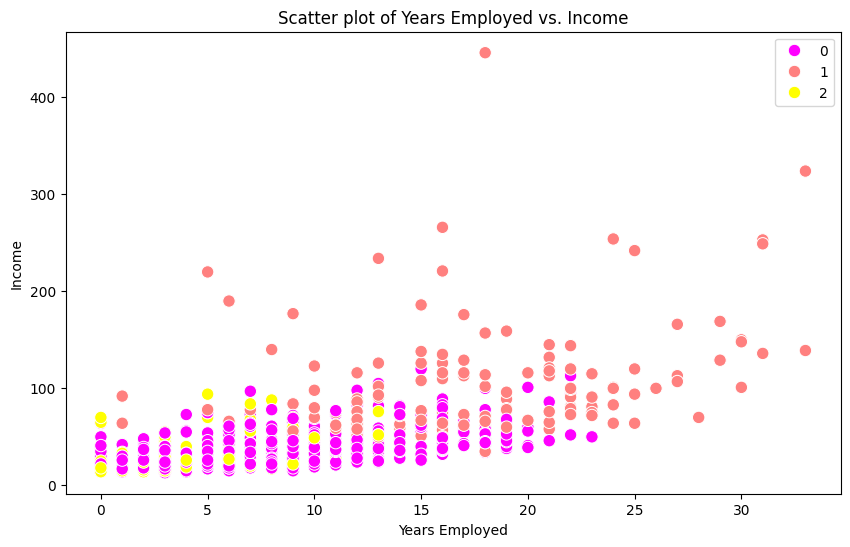

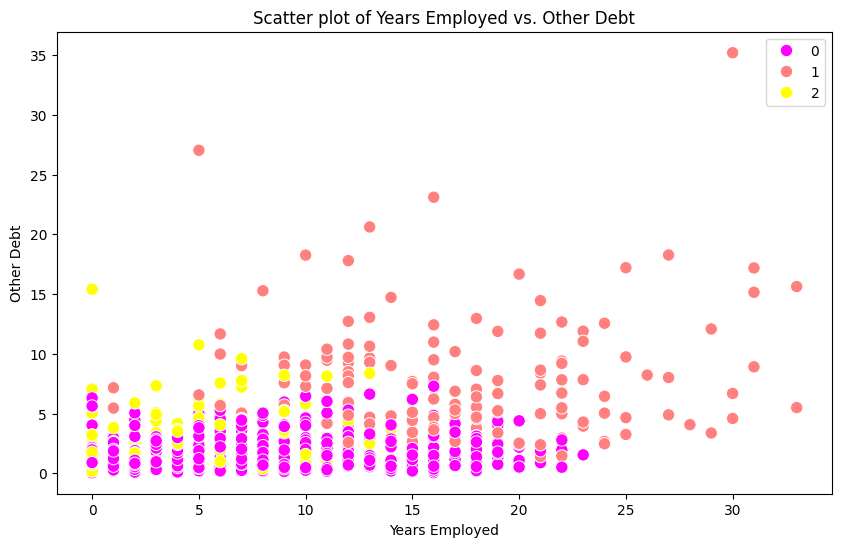

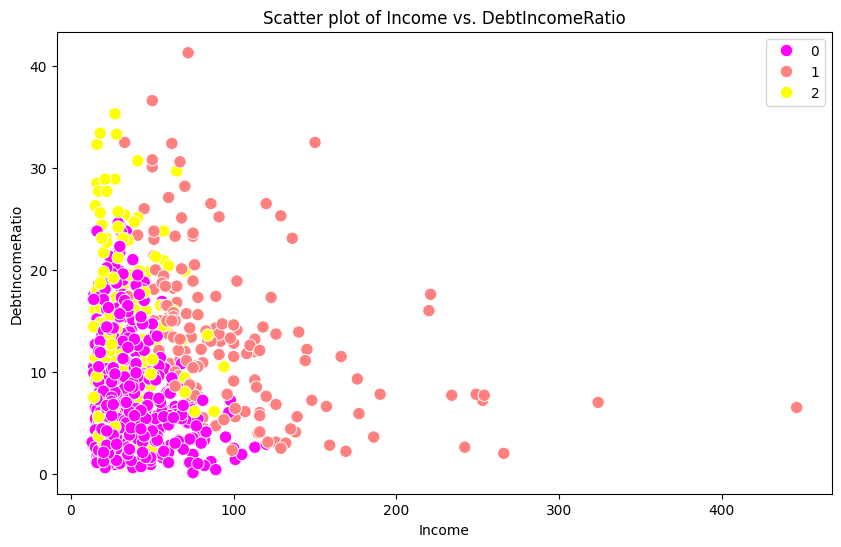

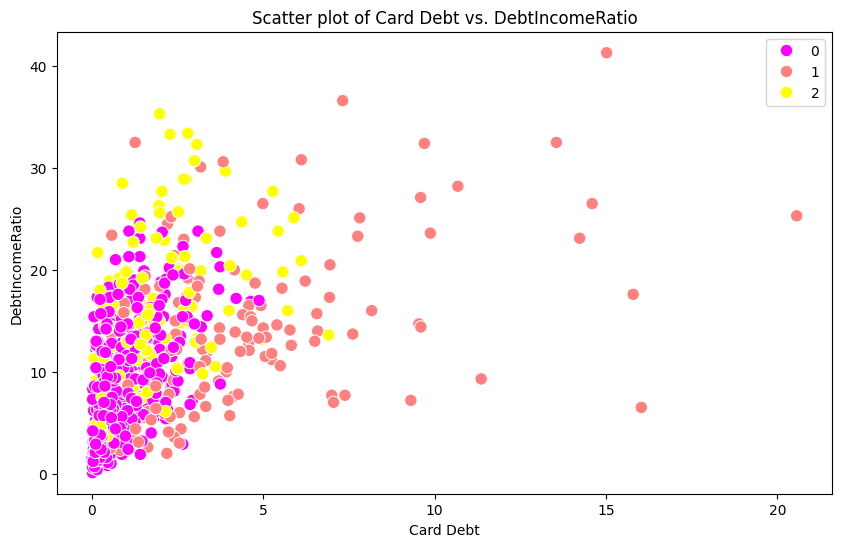

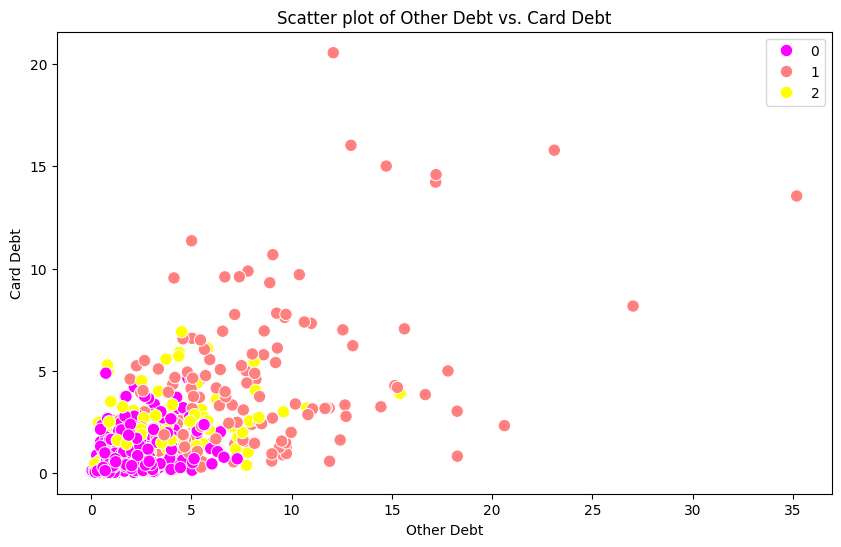

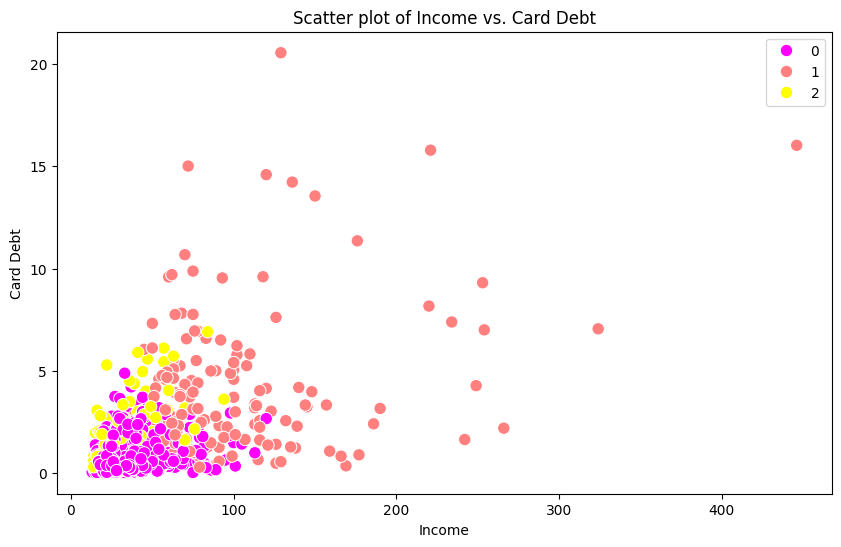

In [ ]:
# Visualize scatter plots for selected feature pairs

def pair_visualization(feature_x, feature_y):
    plt.figure(figsize=(10, 6))

    # Scatter plot for each cluster
    sns.scatterplot(x=feature_x, y=feature_y, hue='cluster3', data=df, palette='spring', s=80)

    plt.title(f'Scatter plot of {feature_x} vs. {feature_y}')
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.legend()
    plt.show()

features = [ ('Age', 'Years Employed'),('Age', 'Income'), ('Age', 'Card Debt'), ('Years Employed', 'Card Debt'), ('Years Employed', 'Income'), ('Years Employed', 'Other Debt'), ('Income', 'DebtIncomeRatio'), ('Card Debt', 'DebtIncomeRatio'), ('Other Debt', 'Card Debt'), ('Income', 'Card Debt')]

for feature_x, feature_y in features:
    pair_visualization(feature_x, feature_y)

# Findings and recommendations
1. Offer credit cards with lower credit limits and tailored benefits suitable for individuals early in their careers. For middle age individuals, the credit card company could increase the credit limits and add more benefits since they have a higher expenditure and are more likely to payback.

2. Introduce cards with points such that people can use their points to purchase items from partners.

3. Training high income earners on budgeting, saving, and responsible credit card use to help them build financial literacy.

4. Create different categories for customers to choose/select from eg Gold, silver, bronze for different categories


# Hierarchical clustering

In [ ]:
# Copy of the dataframe
new_data = df.copy()
new_data.head()

Age  Edu  Years Employed  Income  Card Debt  Other Debt  Defaulted  \
0   41    2               6      19      0.124       1.073        0.0   
1   47    1              26     100      4.582       8.218        0.0   
2   33    2              10      57      6.111       5.802        1.0   
3   29    2               4      19      0.681       0.516        0.0   
4   47    1              31     253      9.308       8.908        0.0   

   DebtIncomeRatio  cluster2  cluster3  
0              6.3         0         0  
1             12.8         1         1  
2             20.9         1         2  
3              6.3         0         0  
4              7.2         1         1

In [ ]:
# Creating an Instance of the Standard Scaler
scaler = StandardScaler()
# Fitting and transforming our data.
scaled_new_data = scaler.fit_transform(new_data)

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
model = AgglomerativeClustering(n_clusters=2, linkage='ward')
cluster_labels = model.fit_predict(new_data)
new_data['cluster_label2'] = cluster_labels
new_data.head()

Age  Edu  Years Employed  Income  Card Debt  Other Debt  Defaulted  \
0   41    2               6      19      0.124       1.073        0.0   
1   47    1              26     100      4.582       8.218        0.0   
2   33    2              10      57      6.111       5.802        1.0   
3   29    2               4      19      0.681       0.516        0.0   
4   47    1              31     253      9.308       8.908        0.0   

   DebtIncomeRatio  cluster2  cluster3  cluster_label2  
0              6.3         1         0               1  
1             12.8         0         1               0  
2             20.9         0         2               0  
3              6.3         1         0               1  
4              7.2         0         1               0

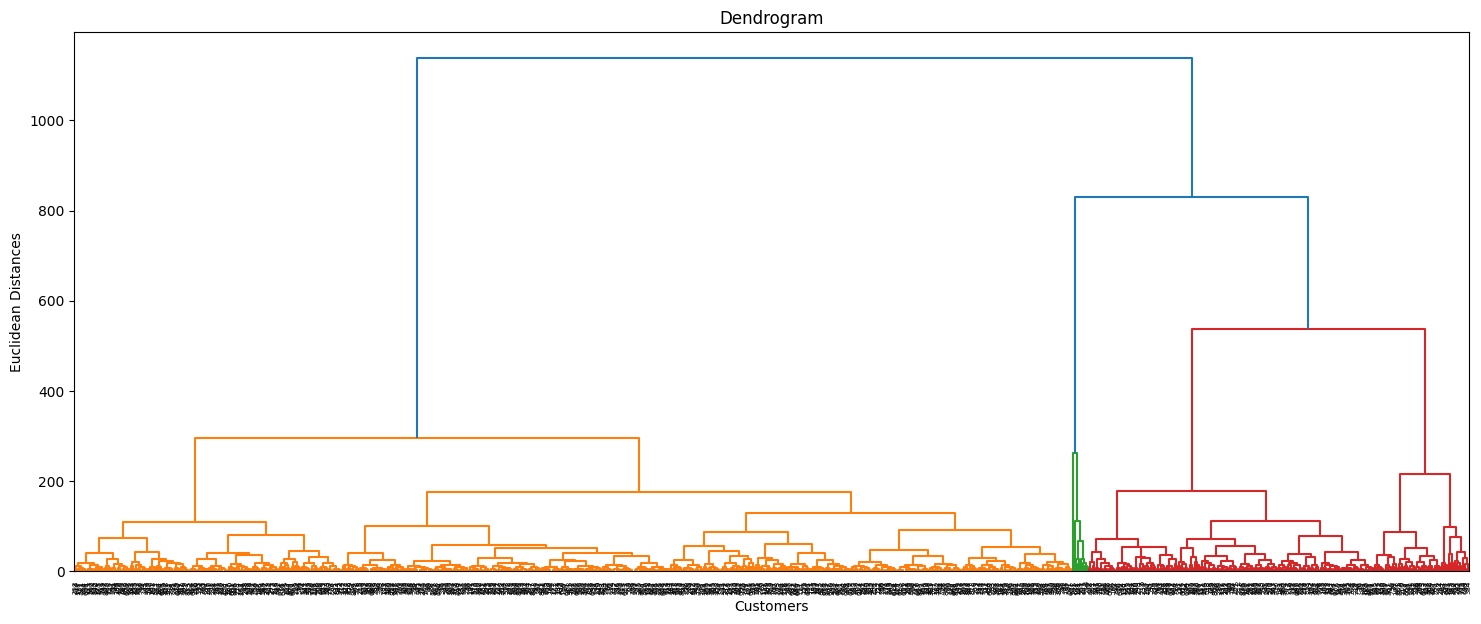

In [ ]:
import scipy.cluster.hierarchy as sch

# Function to create dendrogram for hierarchical clustering
def visualize_dendrogram(data):
    plt.figure(figsize=(18, 7))
    dendrogram = sch.dendrogram(sch.linkage(data, method='ward'))
    plt.title('Dendrogram')
    plt.xlabel('Customers')
    plt.ylabel('Euclidean Distances')
    plt.show()

# Visualize dendrogram for hierarchical clustering
visualize_dendrogram(new_data)